In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

In [2]:
# CIFAR-100 data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)



100%|██████████| 169001437/169001437 [00:03<00:00, 55263175.79it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# Define the CNN model with tanh activation in all layers for CIFAR-100
class CNNTanhCIFAR100(nn.Module):
    def __init__(self):
        super(CNNTanhCIFAR100, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjust the input size based on your input image dimensions
        self.fc2 = nn.Linear(128, 100)  # 100 output classes for CIFAR-100

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))  # Apply tanh to the output of the first convolutional layer
        x = self.pool(torch.tanh(self.conv2(x)))  # Apply tanh to the output of the second convolutional layer
        x = self.pool(torch.tanh(self.conv3(x)))  # Apply tanh to the output of the third convolutional layer
        x = x.view(-1, 128 * 4 * 4)  # Reshape before passing to fully connected layers
        x = torch.tanh(self.fc1(x))  # Apply tanh to the output of the first fully connected layer
        x = self.fc2(x)
        return x



In [4]:
# new code 1
# Choose a percentage of samples for the small dataset
small_dataset_percentage = 0.1  # You can adjust this value

small_train_size = int(small_dataset_percentage * len(train_dataset))
small_test_size = int(small_dataset_percentage * len(test_dataset))

# Create small subsets
small_train_dataset = torch.utils.data.Subset(train_dataset, range(small_train_size))
small_test_dataset = torch.utils.data.Subset(test_dataset, range(small_test_size))

# Create data loaders
small_train_loader = torch.utils.data.DataLoader(dataset=small_train_dataset, batch_size=64, shuffle=True)
small_test_loader = torch.utils.data.DataLoader(dataset=small_test_dataset, batch_size=64, shuffle=False)


Epoch [1/10], Train Accuracy: 0.1324, Test Accuracy: 0.0880
Epoch [2/10], Train Accuracy: 0.1976, Test Accuracy: 0.1490
Epoch [3/10], Train Accuracy: 0.2560, Test Accuracy: 0.1720
Epoch [4/10], Train Accuracy: 0.3070, Test Accuracy: 0.1820
Epoch [5/10], Train Accuracy: 0.3536, Test Accuracy: 0.1880
Epoch [6/10], Train Accuracy: 0.4266, Test Accuracy: 0.2100
Epoch [7/10], Train Accuracy: 0.4820, Test Accuracy: 0.2250
Epoch [8/10], Train Accuracy: 0.5488, Test Accuracy: 0.2240
Epoch [9/10], Train Accuracy: 0.6170, Test Accuracy: 0.2330
Epoch [10/10], Train Accuracy: 0.6844, Test Accuracy: 0.2390


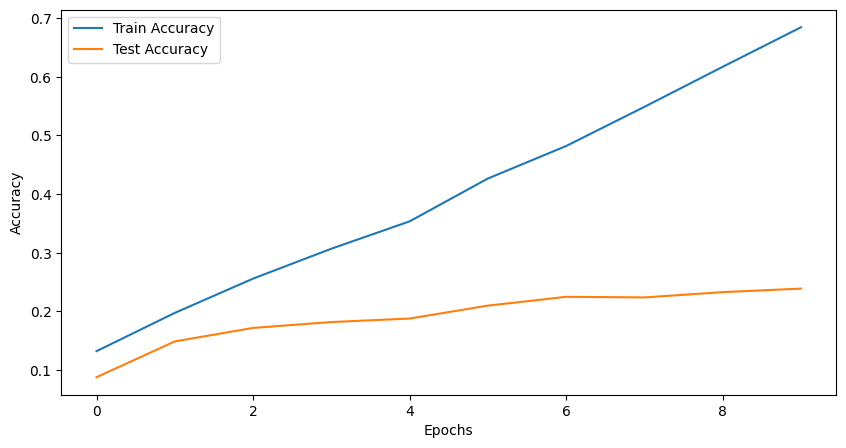

In [5]:
#new code 2

# Instantiate the model
small_model = CNNTanhCIFAR100()
small_criterion = nn.CrossEntropyLoss()
small_optimizer = optim.Adam(small_model.parameters(), lr=0.001)

# Training the model on the small dataset
small_num_epochs = 10
small_train_losses = []
small_test_losses = []
small_train_accuracies = []
small_test_accuracies = []

for epoch in range(small_num_epochs):
    small_model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(small_train_loader):
        # Forward pass
        small_outputs = small_model(images)
        small_loss = small_criterion(small_outputs, labels)

        # Backward pass and optimization
        small_optimizer.zero_grad()
        small_loss.backward()
        small_optimizer.step()

    # Evaluate on the training set
    small_model.eval()
    small_train_preds = []
    small_train_labels = []
    with torch.no_grad():
        for images, labels in small_train_loader:
            small_outputs = small_model(images)
            _, small_train_predicted = torch.max(small_outputs.data, 1)
            small_train_preds.extend(small_train_predicted.numpy())
            small_train_labels.extend(labels.numpy())

    small_train_accuracy = accuracy_score(small_train_labels, small_train_preds)
    small_train_losses.append(small_loss.item())
    small_train_accuracies.append(small_train_accuracy)

    # Evaluate on the test set
    small_test_preds = []
    small_test_labels = []
    with torch.no_grad():
        for images, labels in small_test_loader:
            small_outputs = small_model(images)
            _, small_test_predicted = torch.max(small_outputs.data, 1)
            small_test_preds.extend(small_test_predicted.numpy())
            small_test_labels.extend(labels.numpy())

    small_test_accuracy = accuracy_score(small_test_labels, small_test_preds)
    small_test_loss = small_criterion(small_outputs, labels).item()
    small_test_losses.append(small_test_loss)
    small_test_accuracies.append(small_test_accuracy)

    # Print training statistics
    print('Epoch [{}/{}], Train Accuracy: {:.4f}, Test Accuracy: {:.4f}'.format(epoch + 1, small_num_epochs, small_train_accuracy, small_test_accuracy))

# Plot training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(small_train_accuracies, label='Train Accuracy')
plt.plot(small_test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


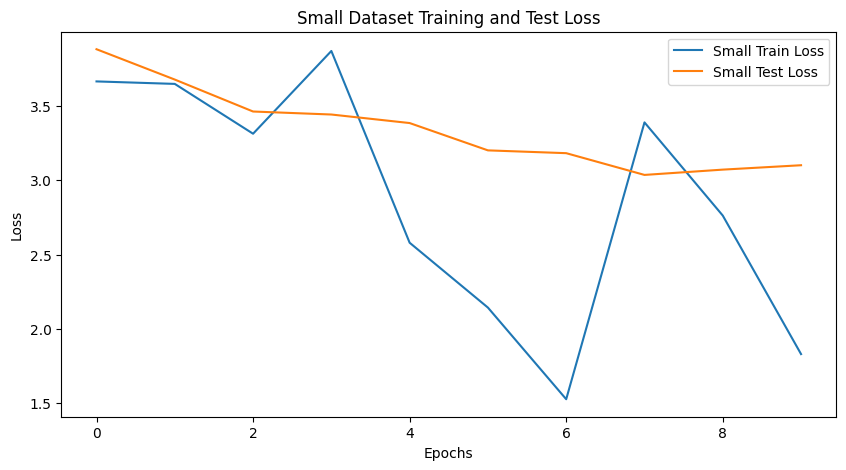

In [6]:
# new code 3

# After the small dataset training loop
plt.figure(figsize=(10, 5))
plt.plot(small_train_losses, label='Small Train Loss')
plt.plot(small_test_losses, label='Small Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Small Dataset Training and Test Loss')
plt.show()


In [7]:
# new code 4
from sklearn.metrics import precision_score, recall_score, f1_score

# After the small dataset training loop
small_test_precision = precision_score(small_test_labels, small_test_preds, average='weighted')
small_test_recall = recall_score(small_test_labels, small_test_preds, average='weighted')
small_test_f1 = f1_score(small_test_labels, small_test_preds, average='weighted')

print("Small Dataset Metrics:")
print("Test Accuracy: {:.4f}".format(small_test_accuracy))
print("Test Precision: {:.4f}".format(small_test_precision))
print("Test Recall: {:.4f}".format(small_test_recall))
print("Test F1 Score: {:.4f}".format(small_test_f1))


Small Dataset Metrics:
Test Accuracy: 0.2390
Test Precision: 0.2444
Test Recall: 0.2390
Test F1 Score: 0.2241


In [8]:
# new code 5
# Load a large subset of the CIFAR-10 dataset
large_dataset_percentage = 0.7  # You can adjust this value

large_train_size = int(large_dataset_percentage * len(train_dataset))
large_test_size = int(large_dataset_percentage * len(test_dataset))

large_train_dataset = torch.utils.data.Subset(train_dataset, range(large_train_size))
large_test_dataset = torch.utils.data.Subset(test_dataset, range(large_test_size))

large_train_loader = torch.utils.data.DataLoader(dataset=large_train_dataset, batch_size=64, shuffle=True)
large_test_loader = torch.utils.data.DataLoader(dataset=large_test_dataset, batch_size=64, shuffle=False)

# Instantiate the model for the large dataset
large_model = CNNTanhCIFAR100()

# Define criterion and optimizer for the large dataset
large_criterion = nn.CrossEntropyLoss()
large_optimizer = optim.Adam(large_model.parameters(), lr=0.001)


Epoch [1/10], Large Train Accuracy: 0.2395, Large Test Accuracy: 0.2226
Epoch [2/10], Large Train Accuracy: 0.3426, Large Test Accuracy: 0.3014
Epoch [3/10], Large Train Accuracy: 0.3959, Large Test Accuracy: 0.3340
Epoch [4/10], Large Train Accuracy: 0.4501, Large Test Accuracy: 0.3523
Epoch [5/10], Large Train Accuracy: 0.4982, Large Test Accuracy: 0.3801
Epoch [6/10], Large Train Accuracy: 0.5398, Large Test Accuracy: 0.3739
Epoch [7/10], Large Train Accuracy: 0.5979, Large Test Accuracy: 0.3869
Epoch [8/10], Large Train Accuracy: 0.6399, Large Test Accuracy: 0.3920
Epoch [9/10], Large Train Accuracy: 0.6810, Large Test Accuracy: 0.3883
Epoch [10/10], Large Train Accuracy: 0.7166, Large Test Accuracy: 0.3899


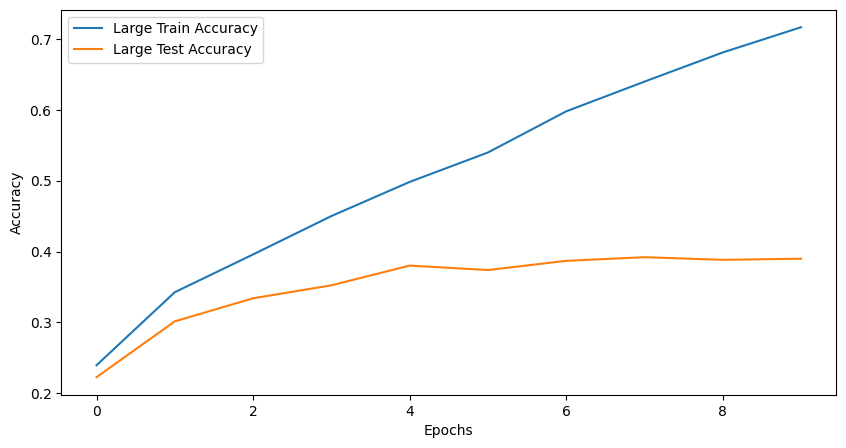

In [9]:
#new code 6

# Training the model on the large dataset
large_num_epochs = 10
large_train_losses = []
large_test_losses = []
large_train_accuracies = []
large_test_accuracies = []

for epoch in range(large_num_epochs):
    large_model.train()
    for i, (images, labels) in enumerate(large_train_loader):
        large_outputs = large_model(images)
        large_loss = large_criterion(large_outputs, labels)
        large_optimizer.zero_grad()
        large_loss.backward()
        large_optimizer.step()

    # Evaluate on the training set
    large_model.eval()
    large_train_preds = []
    large_train_labels = []
    with torch.no_grad():
        for images, labels in large_train_loader:
            large_outputs = large_model(images)
            _, large_train_predicted = torch.max(large_outputs.data, 1)
            large_train_preds.extend(large_train_predicted.numpy())
            large_train_labels.extend(labels.numpy())

    large_train_accuracy = accuracy_score(large_train_labels, large_train_preds)
    large_train_losses.append(large_loss.item())
    large_train_accuracies.append(large_train_accuracy)

    # Evaluate on the test set
    large_test_preds = []
    large_test_labels = []
    with torch.no_grad():
        for images, labels in large_test_loader:
            large_outputs = large_model(images)
            _, large_test_predicted = torch.max(large_outputs.data, 1)
            large_test_preds.extend(large_test_predicted.numpy())
            large_test_labels.extend(labels.numpy())

    large_test_accuracy = accuracy_score(large_test_labels, large_test_preds)
    large_test_loss = large_criterion(large_outputs, labels).item()
    large_test_losses.append(large_test_loss)
    large_test_accuracies.append(large_test_accuracy)

    print('Epoch [{}/{}], Large Train Accuracy: {:.4f}, Large Test Accuracy: {:.4f}'.format(epoch + 1, large_num_epochs, large_train_accuracy, large_test_accuracy))

# Plot training and test accuracies for the large dataset
plt.figure(figsize=(10, 5))
plt.plot(large_train_accuracies, label='Large Train Accuracy')
plt.plot(large_test_accuracies, label='Large Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


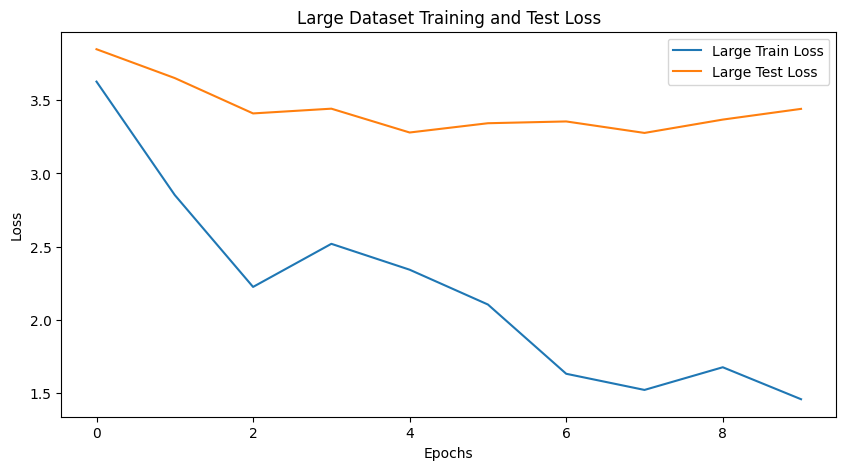

In [10]:
# new code 7
# After the large dataset training loop
plt.figure(figsize=(10, 5))
plt.plot(large_train_losses, label='Large Train Loss')
plt.plot(large_test_losses, label='Large Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Large Dataset Training and Test Loss')
plt.show()


In [11]:
# new code 8
from sklearn.metrics import precision_score, recall_score, f1_score

# After the large dataset training loop
large_test_precision = precision_score(large_test_labels, large_test_preds, average='weighted')
large_test_recall = recall_score(large_test_labels, large_test_preds, average='weighted')
large_test_f1 = f1_score(large_test_labels, large_test_preds, average='weighted')

print("Large Dataset Metrics:")
print("Test Accuracy: {:.4f}".format(large_test_accuracy))
print("Test Precision: {:.4f}".format(large_test_precision))
print("Test Recall: {:.4f}".format(large_test_recall))
print("Test F1 Score: {:.4f}".format(large_test_f1))


Large Dataset Metrics:
Test Accuracy: 0.3899
Test Precision: 0.3954
Test Recall: 0.3899
Test F1 Score: 0.3882


In [12]:
# new code 9
# Instantiate the model for the full dataset
full_model = CNNTanhCIFAR100()

# Define criterion and optimizer for the full dataset
full_criterion = nn.CrossEntropyLoss()
full_optimizer = optim.Adam(full_model.parameters(), lr=0.001)



Epoch [1/10], Full Train Accuracy: 0.2684, Full Test Accuracy: 0.2520
Epoch [2/10], Full Train Accuracy: 0.3497, Full Test Accuracy: 0.3167
Epoch [3/10], Full Train Accuracy: 0.4259, Full Test Accuracy: 0.3684
Epoch [4/10], Full Train Accuracy: 0.4696, Full Test Accuracy: 0.3777
Epoch [5/10], Full Train Accuracy: 0.5119, Full Test Accuracy: 0.3997
Epoch [6/10], Full Train Accuracy: 0.5529, Full Test Accuracy: 0.4114
Epoch [7/10], Full Train Accuracy: 0.5901, Full Test Accuracy: 0.4121
Epoch [8/10], Full Train Accuracy: 0.6477, Full Test Accuracy: 0.4246
Epoch [9/10], Full Train Accuracy: 0.6893, Full Test Accuracy: 0.4288
Epoch [10/10], Full Train Accuracy: 0.7220, Full Test Accuracy: 0.4228


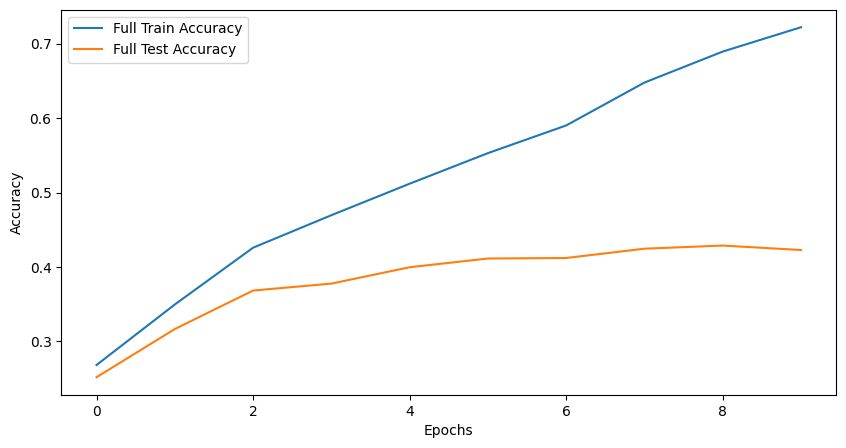

In [13]:
# new code 10
# Training the model on the full dataset
full_num_epochs = 10
full_train_losses = []
full_test_losses = []
full_train_accuracies = []
full_test_accuracies = []

for epoch in range(full_num_epochs):
    full_model.train()
    for i, (images, labels) in enumerate(train_loader):
        full_outputs = full_model(images)
        full_loss = full_criterion(full_outputs, labels)
        full_optimizer.zero_grad()
        full_loss.backward()
        full_optimizer.step()

    # Evaluate on the training set
    full_model.eval()
    full_train_preds = []
    full_train_labels = []
    full_train_loss = 0.0
    with torch.no_grad():
        for images, labels in train_loader:
            full_outputs = full_model(images)
            _, full_train_predicted = torch.max(full_outputs.data, 1)
            full_train_preds.extend(full_train_predicted.numpy())
            full_train_labels.extend(labels.numpy())
            full_train_loss += full_criterion(full_outputs, labels).item()

    full_train_accuracy = accuracy_score(full_train_labels, full_train_preds)
    full_train_loss /= len(train_loader)  # Average over all batches
    full_train_losses.append(full_train_loss)
    full_train_accuracies.append(full_train_accuracy)

    # Evaluate on the test set
    full_test_preds = []
    full_test_labels = []
    full_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            full_outputs = full_model(images)
            _, full_test_predicted = torch.max(full_outputs.data, 1)
            full_test_preds.extend(full_test_predicted.numpy())
            full_test_labels.extend(labels.numpy())
            full_test_loss += full_criterion(full_outputs, labels).item()

    full_test_accuracy = accuracy_score(full_test_labels, full_test_preds)
    full_test_loss /= len(test_loader)  # Average over all batches
    full_test_losses.append(full_test_loss)
    full_test_accuracies.append(full_test_accuracy)

    print('Epoch [{}/{}], Full Train Accuracy: {:.4f}, Full Test Accuracy: {:.4f}'.format(epoch + 1, full_num_epochs, full_train_accuracy, full_test_accuracy))

# Plot training and test accuracies for the full dataset
plt.figure(figsize=(10, 5))
plt.plot(full_train_accuracies, label='Full Train Accuracy')
plt.plot(full_test_accuracies, label='Full Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


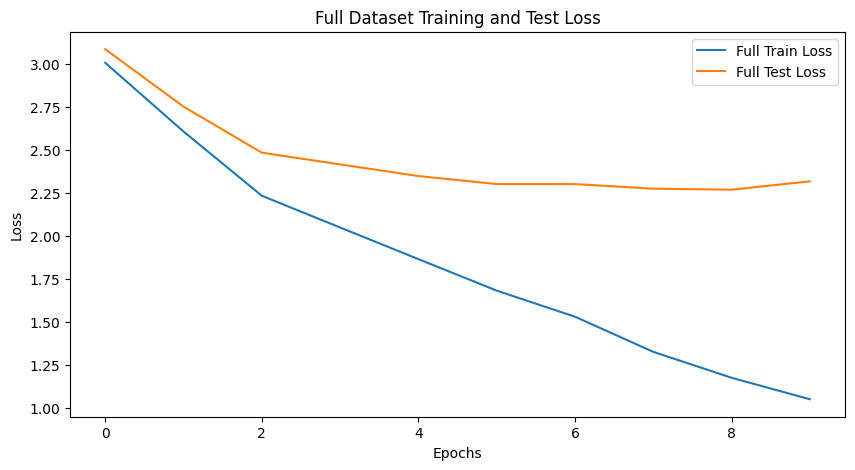

In [14]:
# new code 11
# After the full dataset training loop
plt.figure(figsize=(10, 5))
plt.plot(full_train_losses, label='Full Train Loss')
plt.plot(full_test_losses, label='Full Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Full Dataset Training and Test Loss')
plt.show()



In [15]:
# new code 12
from sklearn.metrics import precision_score, recall_score, f1_score

# After the full dataset training loop
full_test_precision = precision_score(full_test_labels, full_test_preds, average='weighted')
full_test_recall = recall_score(full_test_labels, full_test_preds, average='weighted')
full_test_f1 = f1_score(full_test_labels, full_test_preds, average='weighted')

print("Full Dataset Metrics:")
print("Test Accuracy: {:.4f}".format(full_test_accuracy))
print("Test Precision: {:.4f}".format(full_test_precision))
print("Test Recall: {:.4f}".format(full_test_recall))
print("Test F1 Score: {:.4f}".format(full_test_f1))


Full Dataset Metrics:
Test Accuracy: 0.4228
Test Precision: 0.4260
Test Recall: 0.4228
Test F1 Score: 0.4196


In [ ]:
# do not run
# Create an instance of the CNN model with tanh activation for CIFAR-100
model_tanh_cifar100 = CNNTanhCIFAR100()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification problems
optimizer = optim.Adam(model_tanh_cifar100.parameters(), lr=0.001)  # Adam optimizer

# Training the model for CIFAR-100 with tanh activation
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model_tanh_cifar100(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

# Test the model on CIFAR-100 test dataset with tanh activation
model_tanh_cifar100.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model_tanh_cifar100(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model with tanh activation in all layers for CIFAR-100: {:.2f} %'.format(100 * correct / total))

Epoch [1/10], Step [100/500], Loss: 3.8389
Epoch [1/10], Step [200/500], Loss: 3.5508
Epoch [1/10], Step [300/500], Loss: 3.2451
Epoch [1/10], Step [400/500], Loss: 3.1172
Epoch [1/10], Step [500/500], Loss: 3.1345
Epoch [2/10], Step [100/500], Loss: 2.9421
Epoch [2/10], Step [200/500], Loss: 2.8364
Epoch [2/10], Step [300/500], Loss: 2.9670
Epoch [2/10], Step [400/500], Loss: 2.9433
Epoch [2/10], Step [500/500], Loss: 2.8048
Epoch [3/10], Step [100/500], Loss: 2.6322
Epoch [3/10], Step [200/500], Loss: 2.4888
Epoch [3/10], Step [300/500], Loss: 2.5509
Epoch [3/10], Step [400/500], Loss: 2.2529
Epoch [3/10], Step [500/500], Loss: 2.5594
Epoch [4/10], Step [100/500], Loss: 2.2549
Epoch [4/10], Step [200/500], Loss: 2.1687
Epoch [4/10], Step [300/500], Loss: 2.3593
Epoch [4/10], Step [400/500], Loss: 2.4214
Epoch [4/10], Step [500/500], Loss: 2.2850
Epoch [5/10], Step [100/500], Loss: 1.8700
Epoch [5/10], Step [200/500], Loss: 2.0034
Epoch [5/10], Step [300/500], Loss: 1.6882
Epoch [5/10

In [ ]:
# Create an instance of the CNN model with tanh activation for CIFAR-100
model_tanh_cifar100 = CNNTanhCIFAR100()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification problems
optimizer = optim.Adam(model_tanh_cifar100.parameters(), lr=0.001)  # Adam optimizer

Epoch [1/10], Training Accuracy (Tanh-CIFAR-100): 17.27%, Test Accuracy (Tanh-CIFAR-100): 24.31%
Epoch [2/10], Training Accuracy (Tanh-CIFAR-100): 29.13%, Test Accuracy (Tanh-CIFAR-100): 31.54%
Epoch [3/10], Training Accuracy (Tanh-CIFAR-100): 36.22%, Test Accuracy (Tanh-CIFAR-100): 36.16%
Epoch [4/10], Training Accuracy (Tanh-CIFAR-100): 41.51%, Test Accuracy (Tanh-CIFAR-100): 38.35%
Epoch [5/10], Training Accuracy (Tanh-CIFAR-100): 46.08%, Test Accuracy (Tanh-CIFAR-100): 40.25%
Epoch [6/10], Training Accuracy (Tanh-CIFAR-100): 50.28%, Test Accuracy (Tanh-CIFAR-100): 41.37%
Epoch [7/10], Training Accuracy (Tanh-CIFAR-100): 54.12%, Test Accuracy (Tanh-CIFAR-100): 41.81%
Epoch [8/10], Training Accuracy (Tanh-CIFAR-100): 57.98%, Test Accuracy (Tanh-CIFAR-100): 42.37%
Epoch [9/10], Training Accuracy (Tanh-CIFAR-100): 61.67%, Test Accuracy (Tanh-CIFAR-100): 42.36%
Epoch [10/10], Training Accuracy (Tanh-CIFAR-100): 65.70%, Test Accuracy (Tanh-CIFAR-100): 42.58%


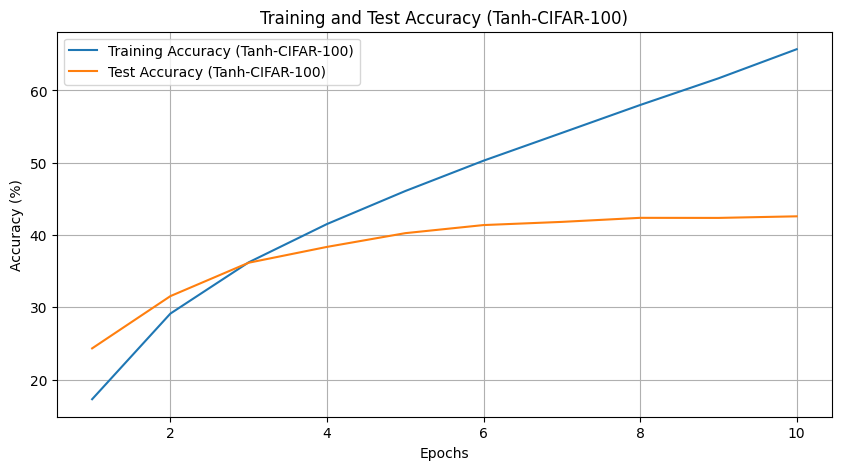

In [ ]:
# Lists to store training and test accuracies
train_accuracies_tanh_cifar100 = []
test_accuracies_tanh_cifar100 = []

# Training the model for CIFAR-100 with Tanh activation
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    train_correct = 0
    train_total = 0
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model_tanh_cifar100(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies_tanh_cifar100.append(train_accuracy)

    # Test the model for CIFAR-100 with Tanh activation
    model_tanh_cifar100.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model_tanh_cifar100(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies_tanh_cifar100.append(test_accuracy)

    print('Epoch [{}/{}], Training Accuracy (Tanh-CIFAR-100): {:.2f}%, Test Accuracy (Tanh-CIFAR-100): {:.2f}%'.format(epoch+1, num_epochs, train_accuracy, test_accuracy))

# Plotting the accuracies for Tanh activation in CIFAR-100
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies_tanh_cifar100, label='Training Accuracy (Tanh-CIFAR-100)')
plt.plot(range(1, num_epochs + 1), test_accuracies_tanh_cifar100, label='Test Accuracy (Tanh-CIFAR-100)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy (Tanh-CIFAR-100)')
plt.legend()
plt.grid(True)
plt.show()
